In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install tf-nightly-2.0-preview


ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


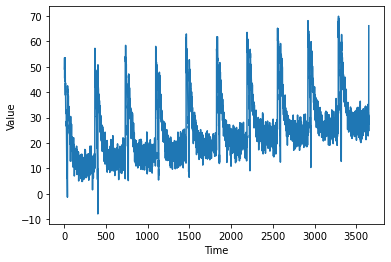

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32#size using training
shuffle_buffer_size = 1000

plot_series(time, series)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)#create a dataset, pass the series to it through from_tenosr_slices
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)#Shift increments the value by 1, Drop_remainder means it will truncate the data, only keeping complete arrays.
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))#flatten the data
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))# split it to everything but last one, and the last one itself with -1:. 
  dataset = dataset.batch(batch_size).prefetch(1)#change it into batch_sizes, sets of batchsize.
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


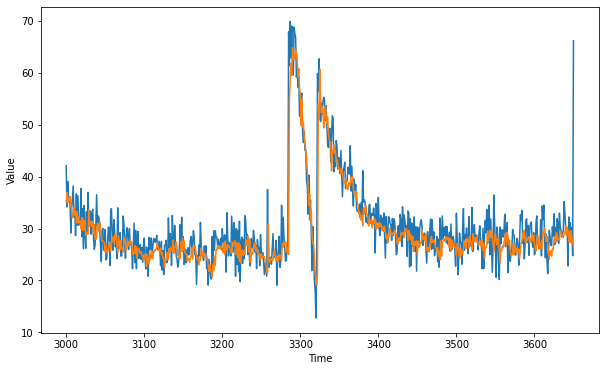

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy() # the mea is pretty good hence our model is good.

3.0291762

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))
model1.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history=model1.fit(dataset,epochs=100,verbose=0,callbacks=[lr_schedule])


(1e-08, 0.001, 0.0, 300.0)

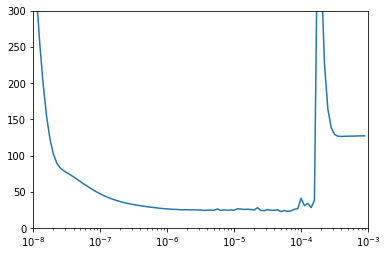

In [ ]:
lrs=1e-8*(10**(np.arange(100)/20))# plotting the loss against the learning rate.  we can inspect the lower part of the table and come up with a value, after which it gets unstable.
plt.semilogx(lrs,history.history["loss"])
plt.axis([1e-8,1e-3,0,300])

Here it looks like it is 7*10-6

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])
model1.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9))
history=model1.fit(dataset,epochs=500,verbose=0)


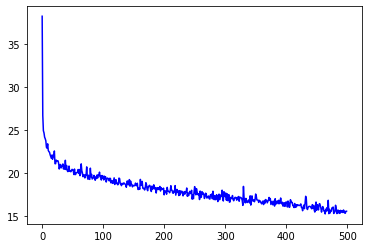

In [ ]:
loss=history.history["loss"]
epochs=range(len(loss))
plt.plot(epochs,loss,'b',label='training loss')
plt.show()

In [ ]:
we can see loss decreases properly, although its very noisy.

In [ ]:
final = []
for time in range(len(series) - window_size):
  final.append(model1.predict(series[time:time + window_size][np.newaxis]))

final = final[split_time-window_size:]
results1 = np.array(final)[:, 0, 0]




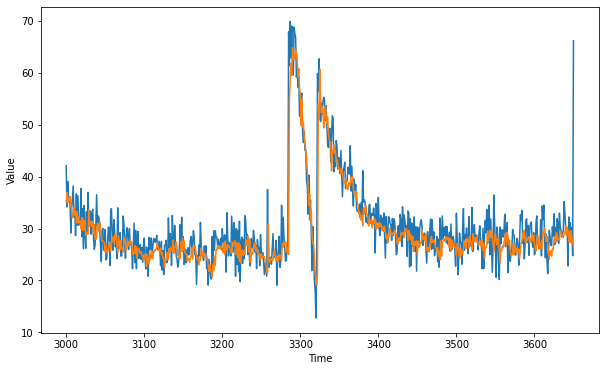

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
results1.shape

(651,)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results1).numpy() 

2.9865944

Hence clearly we have managed to drop the MEA for the function.